# Toy timeseries predictor of functions with form y = f(x). Uses MLP with lagged predictors.

### Read in python modules

In [19]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow 
import keras
idx = pd.IndexSlice
%matplotlib inline

### Define predictors and target

(25000,)
(25000, 100)


Text(0, 0.5, 'functions')

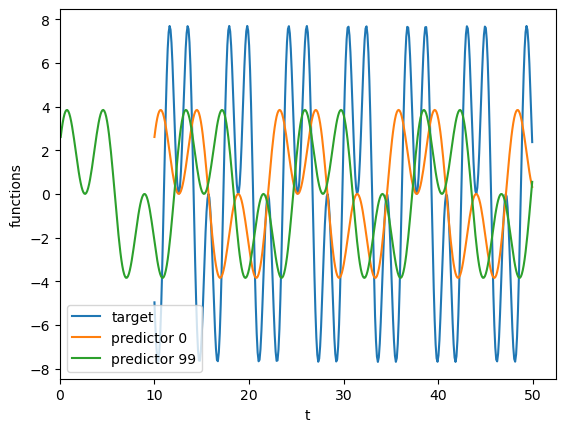

In [20]:
t = np.linspace(0,5000,50000) # number of times
pad = 100
end = int(len(t)/2) 
target = np.append(np.full((pad),np.nan), 10*np.sin(t[pad:end])*np.sin(2*t[pad:end])) 
print(np.shape(target))

npred = 100
predictors = np.empty((len(target),npred))
for i in range(npred):
    predictors[:,i] = np.append(np.full((pad-i),np.nan), 5*np.sin(t[pad:end+i])*np.sin(0.5*t[pad:end+i]))
print(np.shape(predictors))

ts=0
te=500
plt.figure()
plt.plot(t[ts:te],target[ts:te],label="target")
for i in [0,99]: #range(npred)
    plt.plot(t[ts:te],predictors[ts:te,i],label=f"predictor {i}")
plt.legend()
plt.xlabel("t")
plt.xlim(0,)
plt.ylabel("functions")


### Put into dataframes, split into training and test data, remove nans

In [21]:
test_train_ratio = 0.9
eidx = int(0.9*end)

df_input_test = pd.DataFrame(predictors[eidx:,:])
df_nans = df_input_test[df_input_test.isna().any(axis=1)]
df_input_test.loc[df_nans.index,:] = 0
print("df_input_test:",df_input_test.shape)

df_input_train = pd.DataFrame(predictors[:eidx,:])
df_nans = df_input_train[df_input_train.isna().any(axis=1)]
df_input_train.loc[df_nans.index,:] = 0
print("df_input_train:",df_input_train.shape)

df_target_test = pd.DataFrame(target[eidx:])
df_nans = df_target_test[df_target_test.isna().any(axis=1)]
df_target_test.loc[df_nans.index,:] = 0
print("df_target_test:",df_target_test.shape)

df_target_train = pd.DataFrame(target[:eidx])
df_nans = df_target_train[df_target_train.isna().any(axis=1)]
df_target_train.loc[df_nans.index,:] = 0
print("df_target_train:",df_target_train.shape)


df_input_test: (2500, 100)
df_input_train: (22500, 100)
df_target_test: (2500, 1)
df_target_train: (22500, 1)


### Turn back to numpy

In [22]:
input_train = np.copy(df_input_train.to_numpy())
input_test = np.copy(df_input_test.to_numpy())
target_train = np.copy(df_target_train.to_numpy())
target_test = np.copy(df_target_test.to_numpy())

### Scale the input train and target train separately, and use the input train scaling to scale the input test, and use the target train scaling to scale the target test

In [23]:
ranges_input, mins_input = [], []
ranges_target, mins_target = [], []

# test
nfeats = np.shape(input_train)[1]
for i in range(nfeats):
    min0 = np.nanmin(input_train[:,i])
    range0 = np.nanmax(input_train[:,i])-min0
    ranges_input.append(range0)
    mins_input.append(min0)
    input_train[:,i] = (input_train[:,i]-min0)/range0
    input_test[:,i] = (input_test[:,i]-min0)/range0
print("scaled input_train",np.shape(input_train))
print("scaled input_test",np.shape(input_test))

# target
nfeats_target = np.shape(target_train)[1]
for i in range(nfeats_target):
    min0 = np.nanmin(target_train[:,i])
    range0 = np.nanmax(target_train[:,i])-min0
    ranges_target.append(range0)
    mins_target.append(min0)
    target_train[:,i] = (target_train[:,i]-min0)/range0
    target_test[:,i] = (target_test[:,i]-min0)/range0
print("scaled target_train:",np.shape(target_train))
print("scaled target_test:",np.shape(target_test))

print("input:", ranges_input, mins_input)
print("target:", ranges_target, mins_target)


scaled input_train (22500, 100)
scaled input_test (2500, 100)
scaled target_train: (22500, 1)
scaled target_test: (2500, 1)
input: [7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.698003526206614, 7.69800352620

### The ML algorithm function

In [24]:
def build_model_mlp(nlays, nfeats):
    """tensorflow.keras.layers.Dense: a node is connected to all of the nodes in the layer below. 3 layers."""
    input = tensorflow.keras.layers.Input(shape=(nfeats,), name='input')

    x = tensorflow.keras.layers.Dense(64, use_bias=True, activation='relu')(input)
    x = tensorflow.keras.layers.Dense(32, use_bias=True, activation='relu')(x)

    main_output = tensorflow.keras.layers.Dense(nlays, use_bias=True, activation='linear', name='main_output')(x)
    model = tensorflow.keras.models.Model(inputs=[input], outputs=[main_output])
    return model

# Dictionary for the neural network build function (could contain more than one)
model_dict = {'mlp': {'build_func': build_model_mlp,}}

### Build and train the ML algorithm

In [25]:
%%time
nlays=1
# loop over ML algorithms
for model_name in model_dict.keys():
    print(f'building and training model {model_name}')
    # call the Dense function, and add the model function as a new item 'model_object' in the list
    model_dict[model_name]['model_object'] = model_dict[model_name]['build_func'](nlays=nlays, nfeats=nfeats)
    # compile the model function
    model_dict[model_name]['model_object'].compile(loss='mean_absolute_error',optimizer='adam')
    # fit the model function using the training data and target data
    model_dict[model_name]['model_object'].fit([input_train], target_train, epochs=25, batch_size=32, verbose=0)

building and training model mlp
CPU times: user 1min 4s, sys: 1min 10s, total: 2min 14s
Wall time: 39.3 s


### Inference test

In [26]:
# provide test data to the algorithm to obtain a prediction
predictions = {}
for model_name, selected_model in model_dict.items():
  print("model_name:",model_name,", selected_model:",selected_model)
  predictions[model_name] = selected_model['model_object'].predict([input_test])

model_name: mlp , selected_model: {'build_func': <function build_model_mlp at 0x7fae0c36b370>, 'model_object': <keras.engine.functional.Functional object at 0x7fae0ff92650>}
79/79 [==============================] - 0s 1ms/step


### Rescale the target test and predictions

In [27]:
ntargets = np.shape(predictions['mlp'][1])[0]
for i in range(ntargets):
    rescale_min = mins_target[i]
    rescale_range = ranges_target[i]
    ranges_target, mins_target
    target_test[:,i] = target_test[:,i] * rescale_range + rescale_min
    predictions['mlp'] = predictions['mlp'] * rescale_range + rescale_min

### Plot

RMSE: 0.1487461689733634


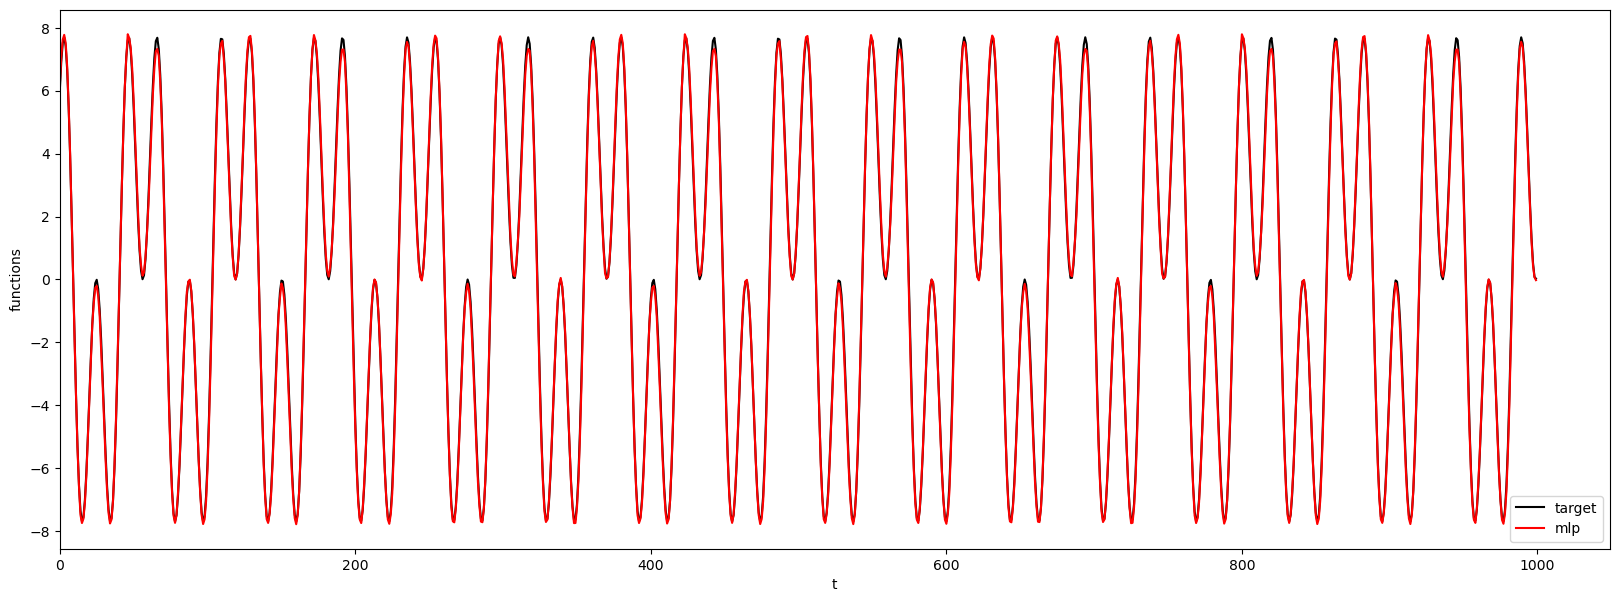

In [28]:
ts = 0
te = 1000
plt.figure(figsize=(20,7))
plt.plot(np.arange(0,len(df_target_test))[ts:te],df_target_test.values[ts:te],linestyle="solid",color="black",label="target")
plt.plot(np.arange(0,len(predictions['mlp']))[ts:te],predictions['mlp'][ts:te],linestyle="solid",color="red",label="mlp")
plt.xlabel("t")
plt.ylabel("functions")
plt.legend()
plt.xlim(0,)

print("RMSE:", np.sqrt(np.mean((predictions['mlp']-df_target_test.values)**2)))